In [178]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import Model, Input


In [179]:
# Data dir
meta_path = 'Dataset/last/XWines_Test_100_wines.csv'
img_dir = 'Dataset/last/Xwines_Test_100_labels/'
# Load metadata
df = pd.read_csv(meta_path)
# Add image paths
df['image_path'] = df['WineID'].astype(str) + '.jpeg'
df['image_path'] = df['image_path'].apply(lambda x: os.path.join(img_dir, x))
# Show available label types
print(df['Type'].unique())

['Red' 'White' 'Dessert/Port' 'Sparkling' 'Rosé' 'Dessert']


In [180]:
print(df.head())

   WineID                          WineName          Type         Elaborate  \
0  100062                     Origem Merlot           Red     Varietal/100%   
1  100191                Reserva Chardonnay         White     Varietal/100%   
2  101847  Dona Antonia Porto Reserva Tawny  Dessert/Port  Assemblage/Blend   
3  102055                    Fine Ruby Port  Dessert/Port  Assemblage/Blend   
4  102079                         Maré Alta         White  Assemblage/Blend   

                                              Grapes  \
0                                         ['Merlot']   
1                                     ['Chardonnay']   
2  ['Touriga Nacional', 'Touriga Franca', 'Tinta ...   
3  ['Tinta Amarela', 'Tinta Barroca', 'Touriga Fr...   
4                ['Loureiro', 'Alvarinho', 'Arinto']   

                                           Harmonize   ABV               Body  \
0  ['Beef', 'Lamb', 'Veal', 'Grilled', 'Pizza', '...  13.0        Full-bodied   
1  ['Rich Fish', 'Seafood'

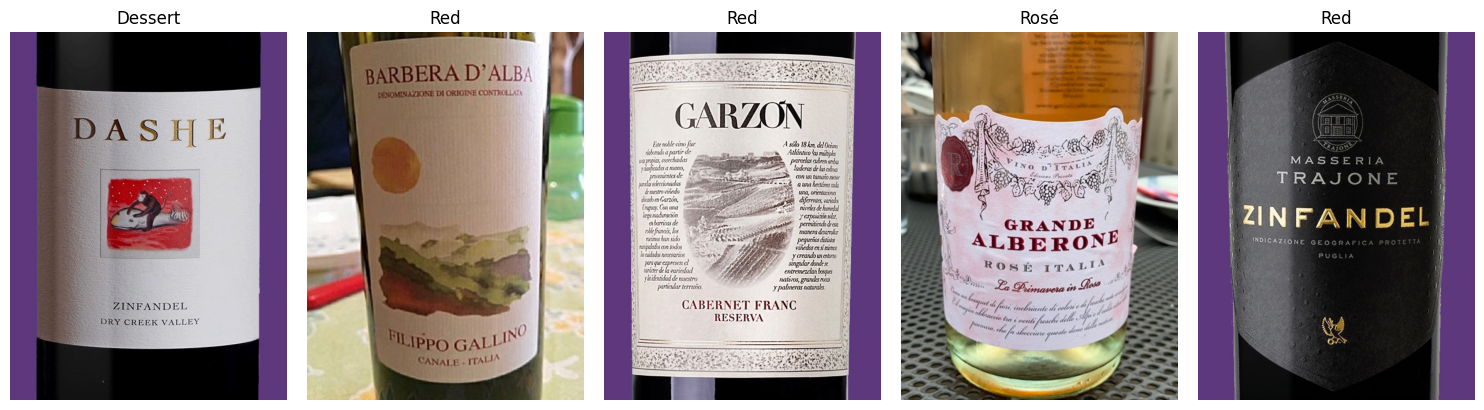

In [181]:
# Visualizing 5 random sample wine labels with their type
sample_df = df.sample(5, random_state=42)
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for ax, (_, row) in zip(axes, sample_df.iterrows()):
    img = mpimg.imread(row['image_path'])
    ax.imshow(img)
    ax.set_title(row['Type'])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [182]:
# Prepare image data for modelling
# 1. Filter only rows with existing image paths
df = df[df['image_path'].apply(os.path.exists)]
# 2. Encode the 'Type' column as numerical labels
label_encoder = LabelEncoder()
df['type_label'] = label_encoder.fit_transform(df['Type'])
# 3. Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['type_label'])
# 4. Set image params
img_height, img_width = 224, 224
batch_size = 32


In [206]:
# Data augmentation and preprocessing for training and validation sets
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=40,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   brightness_range=(0.8, 1.2))
# Data augmentation for validation set (only rescaling)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='image_path',
    y_col='Type',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=None,
    x_col='image_path',
    y_col='Type',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 80 validated image filenames belonging to 6 classes.
Found 20 validated image filenames belonging to 6 classes.


In [207]:
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['type_label']
)
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

Training samples: 80, Validation samples: 20


In [213]:
num_classes = df['Type'].nunique()

model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │     2,986,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,991,302 (11.41 MB)

 Trainable params: 2,991,302 (11.41 MB)

 Non-trainable params: 0 (0.00 B)

In [224]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_baseline_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

epochs = 70

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=epochs,
    callbacks=[checkpoint, early_stopping]
)
model.load_weights('best_baseline_model.h5')
loss, accuracy = model.evaluate(val_generator)
print(f"Best Model Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

Epoch 1/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.5611 - loss: 1.3868
Epoch 1: val_loss improved from inf to 1.46034, saving model to best_baseline_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 525ms/step - accuracy: 0.5552 - loss: 1.3903 - val_accuracy: 0.5000 - val_loss: 1.4603
Epoch 2/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.5194 - loss: 1.4134
Epoch 2: val_loss improved from 1.46034 to 1.46032, saving model to best_baseline_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - accuracy: 0.5240 - loss: 1.4103 - val_accuracy: 0.5000 - val_loss: 1.4603
Epoch 3/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.4778 - loss: 1.5081
Epoch 3: val_loss improved from 1.46032 to 1.46032, saving model to best_baseline_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 557ms/step - accuracy: 0.4927 - loss: 1.4813 - val_accuracy: 0.5000 - val_loss: 1.4603
Epoch 4/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.4778 - loss: 1.4276
Epoch 4: val_loss improved from 1.46032 to 1.46031, saving model to best_baseline_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 750ms/step - accuracy: 0.4927 - loss: 1.4209 - val_accuracy: 0.5000 - val_loss: 1.4603
Epoch 5/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.5646 - loss: 1.3506
Epoch 5: val_loss improved from 1.46031 to 1.46030, saving model to best_baseline_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 570ms/step - accuracy: 0.5578 - loss: 1.3631 - val_accuracy: 0.5000 - val_loss: 1.4603
Epoch 6/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6028 - loss: 1.3314
Epoch 6: val_loss did not improve from 1.46030
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - accuracy: 0.5865 - loss: 1.3487 - val_accuracy: 0.5000 - val_loss: 1.4603
Epoch 7/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.5542 - loss: 1.3542
Epoch 7: val_loss improved from 1.46030 to 1.46029, saving model to best_baseline_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 604ms/step - accuracy: 0.5500 - loss: 1.3658 - val_accuracy: 0.5000 - val_loss: 1.4603
Epoch 8/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.5646 - loss: 1.3286
Epoch 8: val_loss improved from 1.46029 to 1.46027, saving model to best_baseline_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 487ms/step - accuracy: 0.5578 - loss: 1.3466 - val_accuracy: 0.5000 - val_loss: 1.4603
Epoch 9/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.5264 - loss: 1.4543
Epoch 9: val_loss did not improve from 1.46027
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 789ms/step - accuracy: 0.5292 - loss: 1.4408 - val_accuracy: 0.5000 - val_loss: 1.4603
Epoch 10/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.5750 - loss: 1.3104
Epoch 10: val_loss did not improve from 1.46027
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 606ms/step - accuracy: 0.5656 - loss: 1.3330 - val_accuracy: 0.5000 - val_loss: 1.4603
Epoch 11/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.5681 - loss: 1.3617
Epoch 11: val_loss did not improve from 1.46027
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 628ms/step - accuracy: 0.5604 - loss: 1.3714 - val_accuracy: 0.5000 - val_loss: 1.4603
Epoch 12/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.5681 - loss: 1.3433
Epoch 12: val_loss did not improve from 1.46027
3/3 ━━━━━━

In [228]:
# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step - accuracy: 0.5000 - loss: 1.4603
Validation Loss: 1.4603, Validation Accuracy: 0.5000


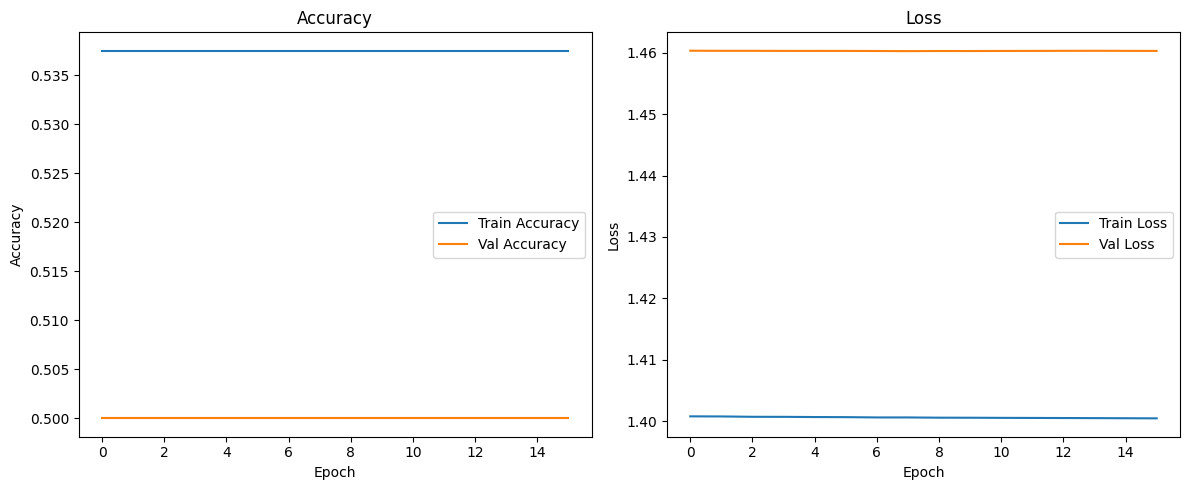

In [229]:
# Plot training & validation accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


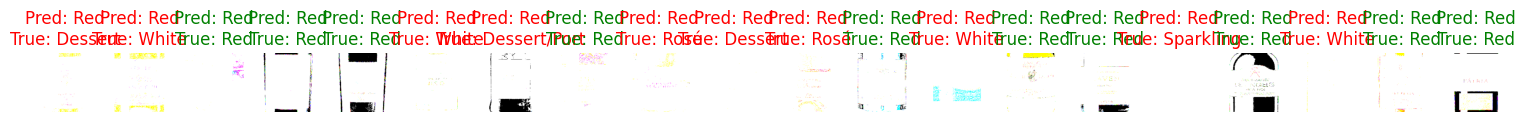

In [230]:
# Predict and visualize results on test images

# Get a batch of test images and true labels
test_images, test_labels = next(val_generator)
# Predict the classes for the test images
pred_probs = model.predict(test_images)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(test_labels, axis=1)
class_names = list(val_generator.class_indices.keys())

# Visualize the first 5 test images with their predicted and true labels
plt.figure(figsize=(15, 6))
for i in range(20):
    plt.subplot(1, 20, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.title(f"Pred: {class_names[pred_classes[i]]}\nTrue: {class_names[true_classes[i]]}",
              color='green' if pred_classes[i] == true_classes[i] else 'red')
plt.tight_layout()
plt.show()



In [231]:
"""# Transfer learning with MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = True  # Freeze the base model

for layer in base_model.layers[:-30]:
    layer.trainable = False  # Freeze all layers except the last 30
    
transfer_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
transfer_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])"""
                        
# Transfer learning with MobileNetV2
inputs = Input(shape=(img_height, img_width, 3))
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = True  # Freeze the base model
for layer in base_model.layers[:-30]:
    layer.trainable = False  # Freeze all layers except the last 30
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

transfer_model = Model(inputs, outputs)
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

/var/folders/rh/khbxvcws7rzgl9vsh4k_t7t40000gn/T/ipykernel_77271/1006863463.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)


In [232]:
# Train the transfer learning model
"""transfer_history = transfer_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=epochs,
    callbacks=[checkpoint, early_stopping]
)"""

v2_early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
v2_checkpoint = ModelCheckpoint('best_v2_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

fine_tune_epochs = 70
fine_tune_history = transfer_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=fine_tune_epochs,
    callbacks=[v2_checkpoint, v2_early_stopping]
)

Epoch 1/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.0875 - loss: 2.6031
Epoch 1: val_loss improved from inf to 2.13655, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 910ms/step - accuracy: 0.0844 - loss: 2.6291 - val_accuracy: 0.0500 - val_loss: 2.1366
Epoch 2/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.1028 - loss: 2.5165
Epoch 2: val_loss improved from 2.13655 to 2.12552, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 788ms/step - accuracy: 0.1021 - loss: 2.5395 - val_accuracy: 0.0500 - val_loss: 2.1255
Epoch 3/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.1194 - loss: 2.8762
Epoch 3: val_loss improved from 2.12552 to 2.11746, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 727ms/step - accuracy: 0.1271 - loss: 2.8223 - val_accuracy: 0.0500 - val_loss: 2.1175
Epoch 4/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.1042 - loss: 2.7173
Epoch 4: val_loss improved from 2.11746 to 2.11081, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.1094 - loss: 2.7083 - val_accuracy: 0.0500 - val_loss: 2.1108
Epoch 5/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.1500 - loss: 2.4184
Epoch 5: val_loss improved from 2.11081 to 2.10456, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 891ms/step - accuracy: 0.1469 - loss: 2.4246 - val_accuracy: 0.0500 - val_loss: 2.1046
Epoch 6/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.1208 - loss: 2.5380
Epoch 6: val_loss improved from 2.10456 to 2.09940, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 626ms/step - accuracy: 0.1187 - loss: 2.5478 - val_accuracy: 0.0500 - val_loss: 2.0994
Epoch 7/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.0292 - loss: 2.6990    
Epoch 7: val_loss improved from 2.09940 to 2.09571, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 613ms/step - accuracy: 0.0437 - loss: 2.6736 - val_accuracy: 0.0500 - val_loss: 2.0957
Epoch 8/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.1583 - loss: 2.3531
Epoch 8: val_loss improved from 2.09571 to 2.09265, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 753ms/step - accuracy: 0.1750 - loss: 2.3353 - val_accuracy: 0.0500 - val_loss: 2.0926
Epoch 9/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.1052 - loss: 2.3794
Epoch 9: val_loss improved from 2.09265 to 2.08857, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 577ms/step - accuracy: 0.1070 - loss: 2.3746 - val_accuracy: 0.1000 - val_loss: 2.0886
Epoch 10/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.1969 - loss: 2.1731
Epoch 10: val_loss improved from 2.08857 to 2.08287, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 506ms/step - accuracy: 0.1977 - loss: 2.1801 - val_accuracy: 0.1000 - val_loss: 2.0829
Epoch 11/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.1990 - loss: 2.2884
Epoch 11: val_loss improved from 2.08287 to 2.07750, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 546ms/step - accuracy: 0.1930 - loss: 2.3040 - val_accuracy: 0.1000 - val_loss: 2.0775
Epoch 12/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.3153 - loss: 2.0275
Epoch 12: val_loss improved from 2.07750 to 2.07239, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 747ms/step - accuracy: 0.2958 - loss: 2.0562 - val_accuracy: 0.1000 - val_loss: 2.0724
Epoch 13/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.1819 - loss: 2.1835
Epoch 13: val_loss improved from 2.07239 to 2.06688, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 624ms/step - accuracy: 0.1896 - loss: 2.1824 - val_accuracy: 0.1000 - val_loss: 2.0669
Epoch 14/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.2135 - loss: 2.1926
Epoch 14: val_loss improved from 2.06688 to 2.06246, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 673ms/step - accuracy: 0.2227 - loss: 2.1800 - val_accuracy: 0.1000 - val_loss: 2.0625
Epoch 15/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.3042 - loss: 2.0360
Epoch 15: val_loss improved from 2.06246 to 2.05802, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 783ms/step - accuracy: 0.3000 - loss: 2.0428 - val_accuracy: 0.1500 - val_loss: 2.0580
Epoch 16/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.1688 - loss: 2.0202
Epoch 16: val_loss improved from 2.05802 to 2.05350, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 711ms/step - accuracy: 0.1672 - loss: 2.0357 - val_accuracy: 0.1500 - val_loss: 2.0535
Epoch 17/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.2500 - loss: 1.9932
Epoch 17: val_loss improved from 2.05350 to 2.04933, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 965ms/step - accuracy: 0.2500 - loss: 1.9868 - val_accuracy: 0.2000 - val_loss: 2.0493
Epoch 18/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.2306 - loss: 2.1190
Epoch 18: val_loss improved from 2.04933 to 2.04525, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 727ms/step - accuracy: 0.2260 - loss: 2.1237 - val_accuracy: 0.2000 - val_loss: 2.0452
Epoch 19/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.2219 - loss: 1.9894
Epoch 19: val_loss improved from 2.04525 to 2.04110, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 822ms/step - accuracy: 0.2195 - loss: 1.9889 - val_accuracy: 0.2000 - val_loss: 2.0411
Epoch 20/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.2264 - loss: 2.0560
Epoch 20: val_loss improved from 2.04110 to 2.03780, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2354 - loss: 2.0413 - val_accuracy: 0.2000 - val_loss: 2.0378
Epoch 21/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.2792 - loss: 2.0028
Epoch 21: val_loss improved from 2.03780 to 2.03499, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 669ms/step - accuracy: 0.2937 - loss: 1.9679 - val_accuracy: 0.2000 - val_loss: 2.0350
Epoch 22/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.2854 - loss: 2.0839
Epoch 22: val_loss improved from 2.03499 to 2.03176, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 951ms/step - accuracy: 0.2797 - loss: 2.0679 - val_accuracy: 0.2000 - val_loss: 2.0318
Epoch 23/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.2365 - loss: 1.9630
Epoch 23: val_loss improved from 2.03176 to 2.02682, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 586ms/step - accuracy: 0.2492 - loss: 1.9407 - val_accuracy: 0.2000 - val_loss: 2.0268
Epoch 24/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2806 - loss: 1.8829  
Epoch 24: val_loss improved from 2.02682 to 2.02119, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2854 - loss: 1.8614 - val_accuracy: 0.2000 - val_loss: 2.0212
Epoch 25/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.3385 - loss: 1.8594
Epoch 25: val_loss improved from 2.02119 to 2.01525, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 658ms/step - accuracy: 0.3320 - loss: 1.8495 - val_accuracy: 0.2000 - val_loss: 2.0153
Epoch 26/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.2931 - loss: 1.8716
Epoch 26: val_loss improved from 2.01525 to 2.01011, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 821ms/step - accuracy: 0.3042 - loss: 1.8780 - val_accuracy: 0.2000 - val_loss: 2.0101
Epoch 27/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.2937 - loss: 1.9226
Epoch 27: val_loss improved from 2.01011 to 2.00600, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - accuracy: 0.2922 - loss: 1.9170 - val_accuracy: 0.2000 - val_loss: 2.0060
Epoch 28/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.3486 - loss: 1.8479
Epoch 28: val_loss improved from 2.00600 to 2.00234, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 767ms/step - accuracy: 0.3458 - loss: 1.8315 - val_accuracy: 0.2000 - val_loss: 2.0023
Epoch 29/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.3389 - loss: 1.7555
Epoch 29: val_loss improved from 2.00234 to 1.99845, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 774ms/step - accuracy: 0.3260 - loss: 1.7820 - val_accuracy: 0.2000 - val_loss: 1.9984
Epoch 30/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.2823 - loss: 1.7614
Epoch 30: val_loss improved from 1.99845 to 1.99471, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 904ms/step - accuracy: 0.2867 - loss: 1.7426 - val_accuracy: 0.2000 - val_loss: 1.9947
Epoch 31/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.4694 - loss: 1.6605
Epoch 31: val_loss improved from 1.99471 to 1.98894, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 775ms/step - accuracy: 0.4490 - loss: 1.6687 - val_accuracy: 0.2500 - val_loss: 1.9889
Epoch 32/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.4250 - loss: 1.7319
Epoch 32: val_loss improved from 1.98894 to 1.98319, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4344 - loss: 1.7141 - val_accuracy: 0.2500 - val_loss: 1.9832
Epoch 33/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.3111 - loss: 1.6949
Epoch 33: val_loss improved from 1.98319 to 1.97756, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3052 - loss: 1.7077 - val_accuracy: 0.2500 - val_loss: 1.9776
Epoch 34/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.3382 - loss: 1.7115
Epoch 34: val_loss improved from 1.97756 to 1.97244, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3380 - loss: 1.7311 - val_accuracy: 0.2500 - val_loss: 1.9724
Epoch 35/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.3514 - loss: 1.8440
Epoch 35: val_loss improved from 1.97244 to 1.96699, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 746ms/step - accuracy: 0.3604 - loss: 1.8221 - val_accuracy: 0.2500 - val_loss: 1.9670
Epoch 36/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.4042 - loss: 1.6148
Epoch 36: val_loss improved from 1.96699 to 1.96187, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 642ms/step - accuracy: 0.4031 - loss: 1.6321 - val_accuracy: 0.3000 - val_loss: 1.9619
Epoch 37/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.5958 - loss: 1.4314
Epoch 37: val_loss improved from 1.96187 to 1.95594, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 806ms/step - accuracy: 0.5813 - loss: 1.4340 - val_accuracy: 0.3000 - val_loss: 1.9559
Epoch 38/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4778 - loss: 1.4621  
Epoch 38: val_loss improved from 1.95594 to 1.95039, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4615 - loss: 1.4938 - val_accuracy: 0.3000 - val_loss: 1.9504
Epoch 39/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.4347 - loss: 1.6264
Epoch 39: val_loss improved from 1.95039 to 1.94432, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 766ms/step - accuracy: 0.4385 - loss: 1.6330 - val_accuracy: 0.3000 - val_loss: 1.9443
Epoch 40/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5222 - loss: 1.5009  
Epoch 40: val_loss improved from 1.94432 to 1.93741, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.5073 - loss: 1.5189 - val_accuracy: 0.3500 - val_loss: 1.9374
Epoch 41/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.4698 - loss: 1.5709
Epoch 41: val_loss improved from 1.93741 to 1.93119, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4742 - loss: 1.5614 - val_accuracy: 0.3500 - val_loss: 1.9312
Epoch 42/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.5000 - loss: 1.4903
Epoch 42: val_loss improved from 1.93119 to 1.92549, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4844 - loss: 1.5164 - val_accuracy: 0.3500 - val_loss: 1.9255
Epoch 43/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.3917 - loss: 1.7207
Epoch 43: val_loss improved from 1.92549 to 1.92038, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 812ms/step - accuracy: 0.4000 - loss: 1.7141 - val_accuracy: 0.3500 - val_loss: 1.9204
Epoch 44/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.4917 - loss: 1.4979
Epoch 44: val_loss improved from 1.92038 to 1.91662, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 826ms/step - accuracy: 0.4875 - loss: 1.5173 - val_accuracy: 0.3500 - val_loss: 1.9166
Epoch 45/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.4417 - loss: 1.6791
Epoch 45: val_loss improved from 1.91662 to 1.91299, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 792ms/step - accuracy: 0.4437 - loss: 1.6801 - val_accuracy: 0.3500 - val_loss: 1.9130
Epoch 46/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.4406 - loss: 1.7762
Epoch 46: val_loss improved from 1.91299 to 1.91013, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 876ms/step - accuracy: 0.4461 - loss: 1.7493 - val_accuracy: 0.3500 - val_loss: 1.9101
Epoch 47/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.4771 - loss: 1.5655
Epoch 47: val_loss improved from 1.91013 to 1.90674, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 883ms/step - accuracy: 0.4734 - loss: 1.5600 - val_accuracy: 0.3500 - val_loss: 1.9067
Epoch 48/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.5156 - loss: 1.4440
Epoch 48: val_loss improved from 1.90674 to 1.90266, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5117 - loss: 1.4575 - val_accuracy: 0.3500 - val_loss: 1.9027
Epoch 49/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.4917 - loss: 1.4395
Epoch 49: val_loss improved from 1.90266 to 1.89759, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4875 - loss: 1.4448 - val_accuracy: 0.3500 - val_loss: 1.8976
Epoch 50/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.5611 - loss: 1.4067
Epoch 50: val_loss improved from 1.89759 to 1.89224, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.5552 - loss: 1.4133 - val_accuracy: 0.3500 - val_loss: 1.8922
Epoch 51/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.4715 - loss: 1.6525
Epoch 51: val_loss improved from 1.89224 to 1.88718, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 840ms/step - accuracy: 0.4755 - loss: 1.6369 - val_accuracy: 0.3500 - val_loss: 1.8872
Epoch 52/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.5097 - loss: 1.3460
Epoch 52: val_loss improved from 1.88718 to 1.88298, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 811ms/step - accuracy: 0.5042 - loss: 1.3611 - val_accuracy: 0.3500 - val_loss: 1.8830
Epoch 53/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.4833 - loss: 1.4668
Epoch 53: val_loss improved from 1.88298 to 1.87814, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 688ms/step - accuracy: 0.4906 - loss: 1.4528 - val_accuracy: 0.3500 - val_loss: 1.8781
Epoch 54/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.4819 - loss: 1.5575
Epoch 54: val_loss improved from 1.87814 to 1.87238, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 772ms/step - accuracy: 0.4833 - loss: 1.5689 - val_accuracy: 0.3500 - val_loss: 1.8724
Epoch 55/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.5153 - loss: 1.5389
Epoch 55: val_loss improved from 1.87238 to 1.86732, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5177 - loss: 1.5301 - val_accuracy: 0.3500 - val_loss: 1.8673
Epoch 56/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.5542 - loss: 1.4975
Epoch 56: val_loss improved from 1.86732 to 1.86167, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 732ms/step - accuracy: 0.5500 - loss: 1.4883 - val_accuracy: 0.3500 - val_loss: 1.8617
Epoch 57/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.5056 - loss: 1.3878
Epoch 57: val_loss improved from 1.86167 to 1.85726, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 695ms/step - accuracy: 0.4979 - loss: 1.3890 - val_accuracy: 0.3500 - val_loss: 1.8573
Epoch 58/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.5406 - loss: 1.4765
Epoch 58: val_loss improved from 1.85726 to 1.85340, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 598ms/step - accuracy: 0.5336 - loss: 1.4798 - val_accuracy: 0.3500 - val_loss: 1.8534
Epoch 59/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.4708 - loss: 1.6748
Epoch 59: val_loss improved from 1.85340 to 1.84904, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 811ms/step - accuracy: 0.4719 - loss: 1.6636 - val_accuracy: 0.3500 - val_loss: 1.8490
Epoch 60/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.4635 - loss: 1.5641
Epoch 60: val_loss improved from 1.84904 to 1.84445, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 647ms/step - accuracy: 0.4570 - loss: 1.5687 - val_accuracy: 0.3500 - val_loss: 1.8445
Epoch 61/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.4472 - loss: 1.5238
Epoch 61: val_loss improved from 1.84445 to 1.84046, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4573 - loss: 1.5212 - val_accuracy: 0.3500 - val_loss: 1.8405
Epoch 62/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.5813 - loss: 1.3194
Epoch 62: val_loss improved from 1.84046 to 1.83691, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5828 - loss: 1.3163 - val_accuracy: 0.3500 - val_loss: 1.8369
Epoch 63/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4750 - loss: 1.4747
Epoch 63: val_loss improved from 1.83691 to 1.83319, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4781 - loss: 1.4760 - val_accuracy: 0.3500 - val_loss: 1.8332
Epoch 64/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5056 - loss: 1.6574  
Epoch 64: val_loss improved from 1.83319 to 1.82941, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5135 - loss: 1.6324 - val_accuracy: 0.3500 - val_loss: 1.8294
Epoch 65/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.6323 - loss: 1.3083
Epoch 65: val_loss improved from 1.82941 to 1.82600, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 684ms/step - accuracy: 0.6242 - loss: 1.3253 - val_accuracy: 0.3500 - val_loss: 1.8260
Epoch 66/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.4948 - loss: 1.4457
Epoch 66: val_loss improved from 1.82600 to 1.82247, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 880ms/step - accuracy: 0.4961 - loss: 1.4714 - val_accuracy: 0.3500 - val_loss: 1.8225
Epoch 67/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.4514 - loss: 1.7160
Epoch 67: val_loss improved from 1.82247 to 1.81830, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4635 - loss: 1.6810 - val_accuracy: 0.3500 - val_loss: 1.8183
Epoch 68/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5847 - loss: 1.2312  
Epoch 68: val_loss improved from 1.81830 to 1.81429, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5698 - loss: 1.2389 - val_accuracy: 0.3500 - val_loss: 1.8143
Epoch 69/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.5236 - loss: 1.4845
Epoch 69: val_loss improved from 1.81429 to 1.81101, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 834ms/step - accuracy: 0.5146 - loss: 1.4883 - val_accuracy: 0.3500 - val_loss: 1.8110
Epoch 70/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5865 - loss: 1.3314
Epoch 70: val_loss improved from 1.81101 to 1.80839, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5867 - loss: 1.3346 - val_accuracy: 0.3500 - val_loss: 1.8084
Restoring model weights from the end of the best epoch: 70.


In [199]:
# Evaluate the transfer learning model
loss, accuracy = transfer_model.evaluate(val_generator)
print(f"Transfer Learning Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.5000 - loss: 1.5012
Transfer Learning Validation Loss: 1.5012, Validation Accuracy: 0.5000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.5000 - loss: 1.5012
Transfer Learning Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}


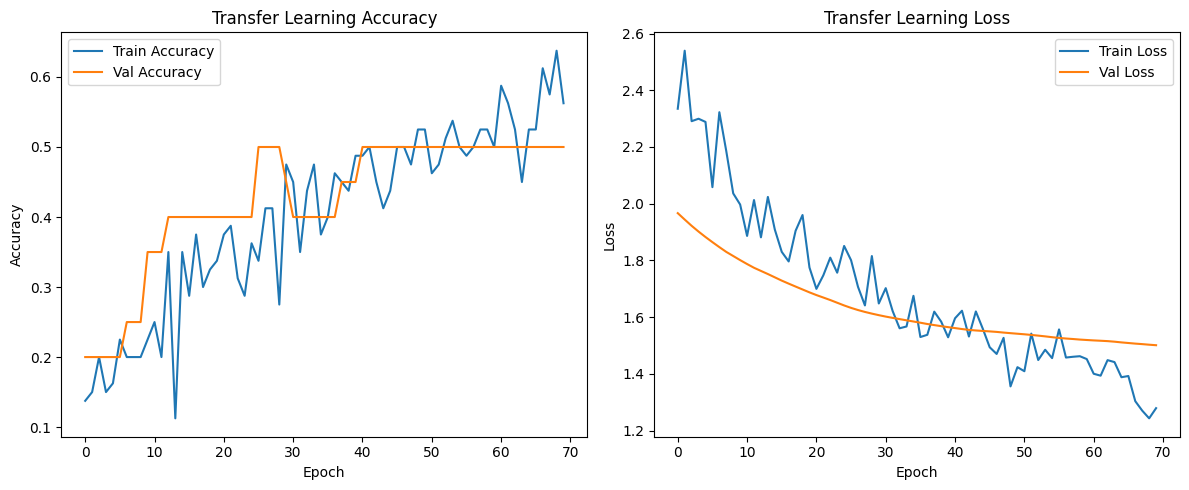

In [200]:
# Evaluate and visualize transfer learning model results
# Evaluate on validation data
loss, accuracy = transfer_model.evaluate(val_generator)
print("Transfer Learning Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")
# Plot training & validation accuracy and loss curves for transfer learning
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Transfer Learning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Val Loss')
plt.title('Transfer Learning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


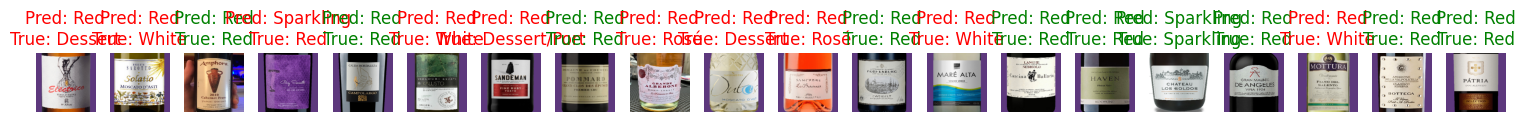

In [201]:
test_images, test_labels = next(val_generator)
# Predict the classes for the test images using the transfer learning model
pred_probs_transfer = transfer_model.predict(test_images)
pred_classes_transfer = np.argmax(pred_probs_transfer, axis=1)
true_classes_transfer = np.argmax(test_labels, axis=1)
# Visualize the first 5 test images with their predicted and true labels using transfer learning
plt.figure(figsize=(15, 6))
for i in range(20):
    plt.subplot(1, 20, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.title(f"Pred: {class_names[pred_classes_transfer[i]]}\nTrue: {class_names[true_classes_transfer[i]]}",
              color='green' if pred_classes_transfer[i] == true_classes_transfer[i] else 'red')
plt.tight_layout()
plt.show()

In [202]:
v3_inputs = Input(shape=(img_height, img_width, 3))
base_model_v3 = MobileNetV3Small(weights='imagenet', include_top=False, input_tensor=v3_inputs)
base_model_v3.trainable = True  # Freeze the base model
for layer in base_model_v3.layers[:-30]:
    layer.trainable = False  # Freeze all layers except the last 30
v3_x = layers.GlobalAveragePooling2D()(base_model_v3.output)
v3_x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(v3_x)
v3_x = layers.Dropout(0.5)(v3_x)
v3_outputs = layers.Dense(num_classes, activation='softmax')(v3_x)
v3_transfer_model = Model(v3_inputs, v3_outputs)
v3_transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [205]:
v3_early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
v3_checkpoint = ModelCheckpoint('best_v3_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

fine_tune_epochs = 70
fine_tune_history = v3_transfer_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=fine_tune_epochs,
    callbacks=[v3_checkpoint, v3_early_stopping]
)

Epoch 1/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.1125 - loss: 2.2730
Epoch 1: val_loss improved from inf to 2.06846, saving model to best_v3_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 445ms/step - accuracy: 0.1219 - loss: 2.2604 - val_accuracy: 0.0500 - val_loss: 2.0685
Epoch 2/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.1979 - loss: 2.2246
Epoch 2: val_loss did not improve from 2.06846
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step - accuracy: 0.1953 - loss: 2.2214 - val_accuracy: 0.0500 - val_loss: 2.0692
Epoch 3/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.2049 - loss: 2.3753
Epoch 3: val_loss did not improve from 2.06846
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.2005 - loss: 2.3600 - val_accuracy: 0.0500 - val_loss: 2.0700
Epoch 4/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.0594 - loss: 2.4277
Epoch 4: val_loss did not improve from 2.06846
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step - accuracy: 0.0695 - loss: 2.4067 - val_accuracy: 0.0500 - val_loss: 2.0708
Epoch 5/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.1778 - loss: 2.2605
Epoch 5: val_loss did not improve from 2.06846
3/3 ━━━━━━━━━━━━